<a href="https://colab.research.google.com/github/ValentinCA28/Data/blob/main/london_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
# --- INSTALLATIONS ---
!pip install -q geopandas folium pyngrok streamlit

# --- IMPORTS ---
import pandas as pd
import numpy as np
import geopandas as gpd
import folium
from folium.plugins import HeatMap
from shapely.geometry import Point, Polygon
import warnings; warnings.filterwarnings('ignore')

print("Setup terminé.")

Setup terminé.


In [71]:
# --- CHARGEMENT ---
df = pd.read_csv('LFB Incident data from 2024 onwards.csv', sep=";")
df2 = pd.read_csv('LFB Mobilisation data from 2025.csv', sep=",")

# --- NETTOYAGE ---
df['IncidentNumber'] = df['IncidentNumber'].astype(str).str.strip()
df2['IncidentNumber'] = df2['IncidentNumber'].astype(str).str.strip()
df = df.dropna(subset=['IncidentNumber', 'FirstPumpArriving_AttendanceTime'])
df2 = df2.dropna(subset=['IncidentNumber'])

# --- CORRECTION LAT/LON (virgule → point) ---
for col in ['Latitude', 'Longitude']:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(',', '.').replace('nan', np.nan)
        df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna(subset=['Latitude', 'Longitude'])

# --- TEMPS DE RÉPONSE ---
df['TempsReponse_min'] = df['FirstPumpArriving_AttendanceTime'] / 60
df = df.drop_duplicates('IncidentNumber')

print(f"Incidents valides : {len(df)}")

Incidents valides : 88683


In [72]:
# --- CORRECTION DATE (janv → Jan) ---
mois_fr = {
    'janv': 'Jan', 'févr': 'Feb', 'mars': 'Mar', 'avr': 'Apr', 'mai': 'May',
    'juin': 'Jun', 'juil': 'Jul', 'août': 'Aug', 'sept': 'Sep', 'oct': 'Oct',
    'nov': 'Nov', 'déc': 'Dec'
}

def replace_fr_months(date_str):
    if pd.isna(date_str):
        return date_str
    for fr, en in mois_fr.items():
        date_str = date_str.replace(fr, en)
    return date_str

# 1. Créer la chaîne brute Date + Time
raw_dates = df['DateOfCall'].astype(str) + ' ' + df['TimeOfCall'].astype(str)

# 2. Remplacer les mois français
clean_dates = raw_dates.apply(replace_fr_months)

# 3. Convertir en datetime (format anglais)
df['DateTimeOfCall'] = pd.to_datetime(
    clean_dates,
    format='%d-%b-%y %H:%M:%S',
    errors='coerce',
    dayfirst=True
)

# --- MÉTÉO SIMULÉE ---
start = pd.Timestamp('2024-01-01')
end = pd.Timestamp('2025-12-31 23:00:00')
dates = pd.date_range(start, end, freq='h')  # 'h' au lieu de 'H'

np.random.seed(42)
n = len(dates)
weather = pd.DataFrame({
    'date': dates,
    'temperature': 8 + 6 * np.sin(2 * np.pi * dates.dayofyear / 365) + np.random.normal(0, 2, n),
    'precipitation': (np.random.exponential(0.1, n) > 0.5).astype(int) * np.random.uniform(0.1, 5, n)
})
weather['temperature'] = weather['temperature'].clip(0, 25)

# --- ARRONDISSEMENT + FUSION ---
df['date_rounded'] = df['DateTimeOfCall'].dt.round('h')
df = df.merge(weather, left_on='date_rounded', right_on='date', how='left').drop(columns='date', errors='ignore')

print("Dates corrigées & météo intégrée avec succès !")
print(df[['IncidentNumber', 'DateTimeOfCall', 'temperature', 'precipitation']].head())

Dates corrigées & météo intégrée avec succès !
    IncidentNumber      DateTimeOfCall  temperature  precipitation
0  000007-01012024 2024-01-01 00:04:21     9.096708            0.0
1  000012-01012024 2024-01-01 00:06:39     9.096708            0.0
2  000017-01012024 2024-01-01 00:09:08     9.096708            0.0
3  000018-01012024 2024-01-01 00:09:10     9.096708            0.0
4  000032-01012024 2024-01-01 00:13:00     9.096708            0.0


In [73]:
# --- CHARGEMENT TOUS LES .SHP ---
import os
shp_files = []
for root, _, files in os.walk('heat_map_data'):
    for f in files:
        if f.endswith('.shp'):
            shp_files.append(os.path.join(root, f))

# Charger un seul (ex: Newham) → ou fusionner tous
gdf_heat = gpd.read_file(shp_files[0]).to_crs('EPSG:4326')

# --- BUFFER 500 m (projection mètres) ---
gdf_inc_m = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs='EPSG:4326').to_crs('EPSG:27700')
gdf_heat_m = gdf_heat.to_crs('EPSG:27700')
gdf_heat_buffer = gdf_heat_m.copy()
gdf_heat_buffer.geometry = gdf_heat_buffer.buffer(500)

# Jointure
joined_m = gpd.sjoin(gdf_inc_m, gdf_heat_buffer, how='left', predicate='intersects')
joined_m['ProcheChaleur'] = ~joined_m['index_right'].isna()
joined = joined_m.to_crs('EPSG:4326')

print(f"Incidents près d'une source (<500m) : {joined['ProcheChaleur'].sum()} ({joined['ProcheChaleur'].mean()*100:.1f}%)")

Incidents près d'une source (<500m) : 7091 (7.7%)


In [74]:
# --- CARTE FOLIUM ---
m = folium.Map(location=[51.5074, -0.1278], zoom_start=11, tiles='CartoDB positron')

# 1. Tous incidents (bleu)
HeatMap(
    data=[[row['Latitude'], row['Longitude']] for _, row in df.iterrows()],
    radius=10, blur=15, gradient={0.2: 'blue', 0.4: 'lightblue'},
    name='Tous incidents'
).add_to(m)

# 2. Incidents proches (rouge)
proche = joined[joined['ProcheChaleur']]
if len(proche) > 0:
    HeatMap(
        data=[[row.geometry.y, row.geometry.x] for _, row in proche.iterrows()],
        radius=12, gradient={0.6: 'orange', 1.0: 'red'},
        name='Près source chaleur'
    ).add_to(m)

# 3. Sources de chaleur
for _, r in gdf_heat.iterrows():
    folium.CircleMarker(
        location=[r.geometry.y, r.geometry.x],
        radius=6, color='darkorange', fill=True, fillOpacity=0.8,
        popup="Source de chaleur (waste heat, data center...)"
    ).add_to(m)

# --- GRILLE 1 km² ---
gdf_inc_m = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs='EPSG:4326').to_crs('EPSG:27700')
bounds = gdf_inc_m.total_bounds
cell_size = 1000
x_coords = np.arange(np.floor(bounds[0]/cell_size)*cell_size, np.ceil(bounds[2]/cell_size)*cell_size, cell_size)
y_coords = np.arange(np.floor(bounds[1]/cell_size)*cell_size, np.ceil(bounds[3]/cell_size)*cell_size, cell_size)

grid_cells = [Polygon([(x,y), (x+cell_size,y), (x+cell_size,y+cell_size), (x,y+cell_size)])
              for x in x_coords for y in y_coords]
grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs='EPSG:27700')
grid_joined = gpd.sjoin(grid, gdf_inc_m, how='left', predicate='intersects')
grid_stats = grid_joined.groupby(level=0).agg({'TempsReponse_min': ['mean', 'count']})
grid_stats.columns = ['temps_moyen', 'count']
grid = grid.reset_index().rename(columns={'index': 'id'}).join(grid_stats).fillna({'temps_moyen': 0, 'count': 0})
grid_latlon = grid.to_crs('EPSG:4326')

for _, row in grid_latlon.iterrows():
    if row['count'] == 0: continue
    time = row['temps_moyen']
    color = 'green' if time <= 5 else 'yellow' if time <= 7 else 'orange' if time <= 10 else 'red'
    folium.Polygon(
        locations=[(lat, lon) for lon, lat in row.geometry.exterior.coords],
        color='black', weight=1, fill_color=color, fill_opacity=0.7,
        popup=f"{int(row['count'])} incidents<br>Moyenne: {time:.1f} min"
    ).add_to(m)

# --- LÉGENDE ---
legend_html = '''
<div style="position: fixed; bottom: 50px; left: 50px; z-index: 1000; background: white; padding: 10px; border-radius: 5px; border: 1px solid #ccc;">
  <b>Légende</b><br>
  <i style="background: blue; opacity: 0.7"></i> Tous incidents<br>
  <i style="background: red; opacity: 0.7"></i> < 500m source chaleur<br>
  <i style="background: orange; opacity: 0.7"></i> Source chaleur<br><br>
  <b>Grille 1 km²</b><br>
  <i style="background: green"></i> < 5 min &nbsp;
  <i style="background: yellow"></i> 5–7 min<br>
  <i style="background: orange"></i> 7–10 min &nbsp;
  <i style="background: red"></i> > 10 min
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# --- SAUVEGARDE ---
m.save('LFB_WasteHeat_FINAL.html')
from google.colab import files
files.download('LFB_WasteHeat_FINAL.html')
print("CARTE FINALE GÉNÉRÉE : LFB_WasteHeat_FINAL.html")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CARTE FINALE GÉNÉRÉE : LFB_WasteHeat_FINAL.html


In [75]:
# =========================================
# CARTE : TEMPS DE RÉPONSE MOYEN (1 km²)
# =========================================

import folium
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon

# --- 1. Préparer les points incidents ---
gdf_inc = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.Longitude, df.Latitude),
    crs='EPSG:4326'
).to_crs('EPSG:27700')  # Projection mètres

# --- 2. Créer grille 1 km² ---
bounds = gdf_inc.total_bounds
cell_size = 1000
x_coords = np.arange(np.floor(bounds[0]/cell_size)*cell_size,
                     np.ceil(bounds[2]/cell_size)*cell_size, cell_size)
y_coords = np.arange(np.floor(bounds[1]/cell_size)*cell_size,
                     np.ceil(bounds[3]/cell_size)*cell_size, cell_size)

grid_cells = [
    Polygon([(x, y), (x + cell_size, y), (x + cell_size, y + cell_size), (x, y + cell_size)])
    for x in x_coords for y in y_coords
]
grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs='EPSG:27700')

# --- 3. Jointure + stats ---
grid_joined = gpd.sjoin(grid, gdf_inc, how='left', predicate='intersects')
grid_stats = grid_joined.groupby(level=0).agg({
    'TempsReponse_min': ['mean', 'count']
})
grid_stats.columns = ['temps_moyen', 'nb_incidents']
grid = grid.reset_index().rename(columns={'index': 'id'}).join(grid_stats)
grid = grid.fillna({'temps_moyen': 0, 'nb_incidents': 0})

# --- 4. Repasser en lat/lon ---
grid_latlon = grid.to_crs('EPSG:4326')

# --- 5. Créer la carte ---
m = folium.Map(location=[51.5074, -0.1278], zoom_start=11, tiles='CartoDB positron')

# Ajouter chaque cellule
for _, row in grid_latlon.iterrows():
    if row['nb_incidents'] == 0:
        continue
    time = row['temps_moyen']
    # Couleur selon objectif LFB
    if time <= 6:
        color = '#2ca02c'  # vert
    elif time <= 8:
        color = '#ff7f0e'  # orange
    else:
        color = '#d62728'  # rouge

    folium.Polygon(
        locations=[(lat, lon) for lon, lat in row.geometry.exterior.coords],
        color='black',
        weight=1,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(
            f"<b>{int(row['nb_incidents'])} incidents</b><br>"
            f"Temps moyen : <b>{time:.1f} min</b>",
            max_width=200
        )
    ).add_to(m)

# --- 6. Légende claire ---
legend_html = '''
<div style="position: fixed; bottom: 20px; left: 20px; z-index: 1000;
            background: white; padding: 12px; border-radius: 8px;
            font-family: Arial; font-size: 13px; border: 1px solid #ccc;">
  <b>Temps de réponse moyen (1ère pompe)</b><br>
  <i style="background: #2ca02c; width: 18px; height: 18px; display: inline-block; border-radius: 3px;"></i> ≤ 6 min (Objectif LFB)<br>
  <i style="background: #ff7f0e; width: 18px; height: 18px; display: inline-block; border-radius: 3px;"></i> 6–8 min<br>
  <i style="background: #d62728; width: 18px; height: 18px; display: inline-block; border-radius: 3px;"></i> > 8 min
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# --- 7. Sauvegarde ---
m.save('LFB_TempsReponse_Grille1km.html')
from google.colab import files
files.download('LFB_TempsReponse_Grille1km.html')

print("CARTE GÉNÉRÉE : LFB_TempsReponse_Grille1km.html")
print(f"→ {grid['nb_incidents'].sum()} incidents | {len(grid[grid['nb_incidents'] > 0])} cellules actives")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CARTE GÉNÉRÉE : LFB_TempsReponse_Grille1km.html
→ 88683 incidents | 1618 cellules actives


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

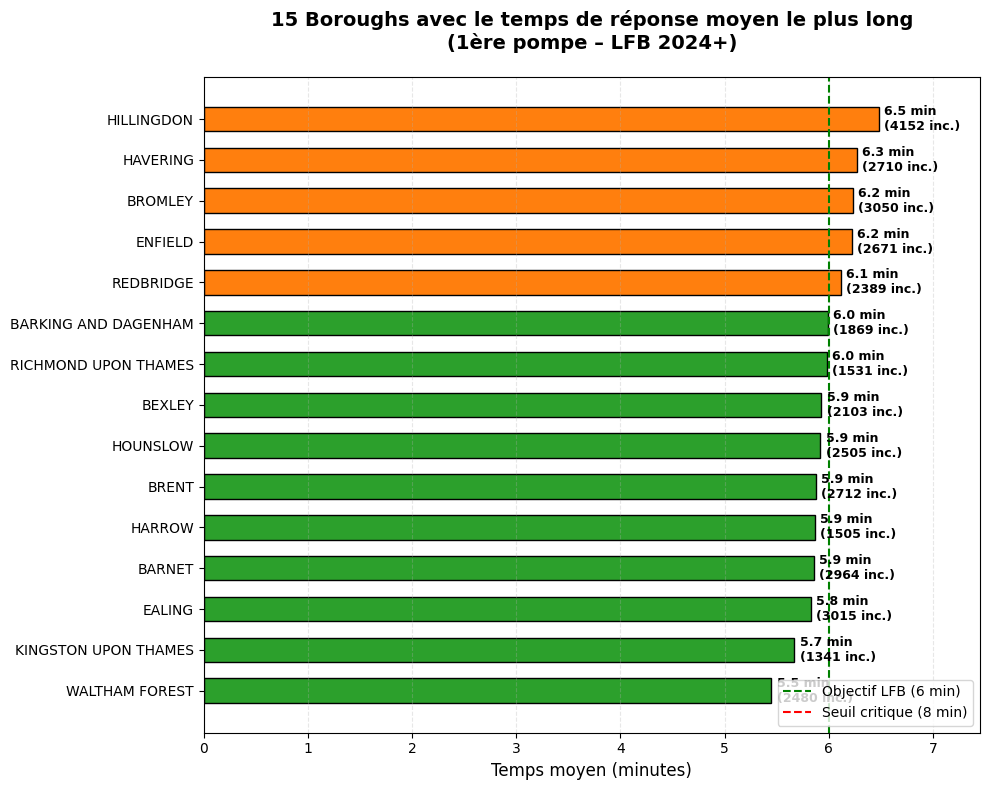

In [76]:
# =============================================
# BARPLOT : 15 BOROUGHS LES PLUS LENTS
# =============================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- 1. Calcul temps moyen par borough ---
response_by_borough = df.groupby('IncGeo_BoroughName')['TempsReponse_min'].agg([
    'mean', 'count'
]).round(2)

# Renommer pour clarté
response_by_borough.columns = ['Temps_moyen_min', 'Nb_incidents']
response_by_borough = response_by_borough.sort_values('Temps_moyen_min', ascending=False)

# --- 2. Top 15 les plus lents ---
top15_lents = response_by_borough.head(15).copy()
top15_lents = top15_lents.sort_values('Temps_moyen_min', ascending=True)  # Pour barh croissant

# --- 3. Barplot horizontal ---
plt.figure(figsize=(10, 8))
colors = ['#d62728' if x > 8 else '#ff7f0e' if x > 6 else '#2ca02c' for x in top15_lents['Temps_moyen_min']]

bars = plt.barh(
    top15_lents.index,
    top15_lents['Temps_moyen_min'],
    color=colors,
    edgecolor='black',
    height=0.6
)

# Ajouter les valeurs sur les barres
for i, (borough, row) in enumerate(top15_lents.iterrows()):
    plt.text(
        row['Temps_moyen_min'] + 0.05,
        i,
        f"{row['Temps_moyen_min']:.1f} min\n({int(row['Nb_incidents'])} inc.)",
        va='center',
        fontsize=9,
        fontweight='bold'
    )

# --- 4. Mise en forme ---
plt.title('15 Boroughs avec le temps de réponse moyen le plus long\n(1ère pompe – LFB 2024+)',
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Temps moyen (minutes)', fontsize=12)
plt.ylabel('')
plt.xlim(0, top15_lents['Temps_moyen_min'].max() * 1.15)

# Lignes cibles LFB
plt.axvline(6, color='green', linestyle='--', linewidth=1.5, label='Objectif LFB (6 min)')
plt.axvline(8, color='red', linestyle='--', linewidth=1.5, label='Seuil critique (8 min)')

# Légende
plt.legend(loc='lower right')

# Grille
plt.grid(axis='x', alpha=0.3, linestyle='--')

# Nettoyage noms boroughs
plt.yticks(fontsize=10)
plt.tight_layout()

# --- 5. Sauvegarde ---
plt.savefig('Top15_Boroughs_Lents.png', dpi=300, bbox_inches='tight')
from google.colab import files
files.download('Top15_Boroughs_Lents.png')

In [108]:
#A GARDER
# =====================================================
# CARTE COMPLÈTE LONDRES : TEMPS + CASERNES + LOGISTIQUE + INDUSTRIEL + FEUX
# =====================================================

import folium
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
import pandas as pd

# --- 1. CASERNES (103) ---
stations_data = {
    'Station Name': ['Acton', 'Addiscombe', 'Barking', 'Barnet', 'Battersea', 'Beckenham', 'Belvedere', 'Bexley', 'Biggin Hill', 'Bow',
                     'Brixton', 'Bromley', 'Camberwell', 'Catford', 'Chelsea', 'Chingford', 'Chiswick', 'Clapham', 'Coulsdon', 'Croydon',
                     'Dagenham', 'Deptford', 'Dockhead', 'Dowgate', 'Ealing', 'East Ham', 'Edmonton', 'Eltham', 'Enfield', 'Erith',
                     'Euston', 'Feltham', 'Finchley', 'Forest Hill', 'Fulham', 'Greenwich', 'Hainault', 'Hammersmith', 'Hampstead', 'Harold Hill',
                     'Harrow', 'Hayes', 'Heathrow', 'Hendon', 'Heston', 'Hillingdon', 'Holloway', 'Hornchurch', 'Hounslow', 'Ilford',
                     'Islington', 'Kensington', 'Kentish Town', 'Kingston', 'Lambeth', 'Lee Green', 'Lewisham', 'Leyton', 'Leytonstone', 'Mill Hill',
                     'Millwall', 'Mitcham', 'New Cross', 'Norbiton', 'North Kensington', 'Northolt', 'Old Kent Road', 'Orpington', 'Paddington', 'Park Royal',
                     'Peckham', 'Plumstead', 'Poplar', 'Purley', 'Richmond', 'Romford', 'Ruislip', 'Shadwell', 'Shoreditch', 'Sidcup',
                     'Soho', 'Southall', 'Southwark', 'Stanmore', 'Stoke Newington', 'Stratford', 'Surbiton', 'Sutton', 'Tooting', 'Tottenham',
                     'Twickenham', 'Uxbridge', 'Walthamstow', 'Wandsworth', 'Wembley', 'West Hampstead', 'West Norwood', 'Whitechapel', 'Willesden', 'Wimbledon',
                     'Woodford', 'Woodside'],
    'Latitude': [51.5080, 51.3800, 51.5390, 51.6530, 51.4700, 51.4080, 51.4860, 51.4410, 51.3080, 51.5320,
                 51.4620, 51.3990, 51.4730, 51.4450, 51.4940, 51.5830, 51.4920, 51.4590, 51.3430, 51.3720,
                 51.5430, 51.4850, 51.5000, 51.5140, 51.5130, 51.5600, 51.5920, 51.4660, 51.6150, 51.4850,
                 51.5270, 51.4420, 51.6120, 51.4330, 51.4860, 51.4780, 51.5920, 51.5030, 51.5530, 51.5890,
                 51.5790, 51.5140, 51.4420, 51.5920, 51.4850, 51.5460, 51.5590, 51.5550, 51.4420, 51.5600,
                 51.5380, 51.4920, 51.5460, 51.4180, 51.4920, 51.4470, 51.4730, 51.5760, 51.5700, 51.5750,
                 51.5020, 51.4250, 51.4850, 51.4050, 51.4940, 51.5460, 51.4920, 51.3960, 51.5160, 51.5340,
                 51.4890, 51.4700, 51.5270, 51.3530, 51.4480, 51.5890, 51.5770, 51.5180, 51.5270, 51.4410,
                 51.5140, 51.5080, 51.5050, 51.6150, 51.5660, 51.5700, 51.4050, 51.3830, 51.4540, 51.5990,
                 51.4480, 51.5490, 51.5920, 51.4620, 51.5520, 51.5460, 51.4620, 51.5180, 51.5420, 51.4180,
                 51.5920, 51.3720],
    'Longitude': [-0.2700, -0.0740, 0.1710, -0.2000, -0.1180, -0.0590, 0.1240, 0.1520, 0.0340, -0.0250,
                  -0.1120, -0.0350, -0.0930, -0.0220, -0.1700, 0.0650, -0.2540, -0.1400, -0.1150, -0.0980,
                  0.1980, -0.0600, -0.0500, -0.0900, -0.3060, 0.1200, 0.0100, 0.0850, 0.0450, 0.1700,
                  -0.1340, -0.4130, -0.2200, -0.0400, -0.2300, 0.0180, 0.1700, -0.2400, -0.1700, 0.2200,
                  -0.3300, -0.4210, -0.4890, -0.3150, -0.3800, -0.4450, -0.1100, 0.2000, -0.3580, 0.1400,
                  -0.1000, -0.1850, -0.1400, -0.3600, -0.1200, -0.0200, -0.0600, 0.0550, 0.0500, -0.2400,
                  -0.0700, -0.1700, -0.0600, -0.3700, -0.2000, -0.3700, -0.0800, 0.0400, -0.1750, -0.2800,
                  -0.0600, 0.1000, -0.0300, -0.0900, -0.3380, 0.2200, -0.4280, -0.0710, -0.0770, 0.1100,
                  -0.1370, -0.3750, -0.0800, -0.3600, -0.0800, 0.0400, -0.3900, -0.1100, -0.1300, -0.1100,
                  -0.3380, -0.4450, 0.0500, -0.1700, -0.3030, -0.1900, -0.0500, -0.0710, -0.2200, -0.1700,
                  0.0600, -0.0980],
    'Borough': ['Ealing', 'Croydon', 'Barking and Dagenham', 'Barnet', 'Wandsworth', 'Bromley', 'Bexley', 'Bexley', 'Bromley', 'Tower Hamlets',
                'Lambeth', 'Bromley', 'Southwark', 'Lewisham', 'Kensington and Chelsea', 'Waltham Forest', 'Hounslow', 'Lambeth', 'Croydon', 'Croydon',
                'Barking and Dagenham', 'Lewisham', 'Southwark', 'City of London', 'Ealing', 'Newham', 'Enfield', 'Greenwich', 'Enfield', 'Bexley',
                'Camden', 'Hounslow', 'Barnet', 'Lewisham', 'Hammersmith and Fulham', 'Greenwich', 'Redbridge', 'Hammersmith and Fulham', 'Camden', 'Havering',
                'Harrow', 'Hillingdon', 'Hillingdon', 'Barnet', 'Hounslow', 'Hillingdon', 'Islington', 'Havering', 'Hounslow', 'Redbridge',
                'Islington', 'Kensington and Chelsea', 'Camden', 'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Lewisham', 'Waltham Forest', 'Waltham Forest', 'Barnet',
                'Tower Hamlets', 'Merton', 'Lewisham', 'Kingston upon Thames', 'Kensington and Chelsea', 'Ealing', 'Southwark', 'Bromley', 'Westminster', 'Ealing',
                'Southwark', 'Greenwich', 'Tower Hamlets', 'Croydon', 'Richmond upon Thames', 'Havering', 'Hillingdon', 'Tower Hamlets', 'Tower Hamlets', 'Bexley',
                'Westminster', 'Ealing', 'Southwark', 'Harrow', 'Hackney', 'Newham', 'Kingston upon Thames', 'Sutton', 'Wandsworth', 'Haringey',
                'Richmond upon Thames', 'Hillingdon', 'Waltham Forest', 'Wandsworth', 'Brent', 'Camden', 'Lambeth', 'Tower Hamlets', 'Brent', 'Merton',
                'Redbridge', 'Croydon']
}
stations_df = pd.DataFrame(stations_data)

# --- 2. GRILLE 1 km² ---
gdf_inc = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs='EPSG:4326').to_crs('EPSG:27700')
bounds = gdf_inc.total_bounds
cell_size = 1000
x_coords = np.arange(np.floor(bounds[0]/cell_size)*cell_size, np.ceil(bounds[2]/cell_size)*cell_size, cell_size)
y_coords = np.arange(np.floor(bounds[1]/cell_size)*cell_size, np.ceil(bounds[3]/cell_size)*cell_size, cell_size)
grid_cells = [Polygon([(x,y), (x+cell_size,y), (x+cell_size,y+cell_size), (x,y+cell_size)]) for x in x_coords for y in y_coords]
grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs='EPSG:27700')
grid_joined = gpd.sjoin(grid, gdf_inc, how='left', predicate='intersects')
grid_stats = grid_joined.groupby(level=0).agg({'TempsReponse_min': ['mean', 'count']})
grid_stats.columns = ['temps_moyen', 'nb_incidents']
grid = grid.reset_index().rename(columns={'index': 'id'}).join(grid_stats).fillna(0)
grid_latlon = grid.to_crs('EPSG:4326')

# --- 3. ZONES LOGISTIQUES (camion) ---
logistique_zones = pd.DataFrame({
    'nom': ['Dagenham Logistics Park', 'Barking Riverside', 'Purfleet Industrial Estate', 'Thurrock Park', 'Tilbury Docks', 'Park Royal', 'Heathrow Cargo', 'Wembley Industrial', 'Croydon Logistics', 'Enfield Distribution'],
    'lat': [51.535, 51.525, 51.485, 51.490, 51.460, 51.534, 51.470, 51.552, 51.372, 51.614],
    'lon': [0.160, 0.140, 0.190, 0.170, 0.250, -0.280, -0.450, -0.303, -0.098, -0.048],
    'type': 'Logistique'
})

# --- 4. ZONES INDUSTRIELLES (usine) ---
industriel_zones = pd.DataFrame({
    'nom': ['Ford Dagenham', 'Cray Valley Chemicals', 'Procter & Gamble Purfleet', 'Romford Industrial Park', 'Tilbury Power Station', 'Acton Works', 'Hounslow Industrial', 'Wandsworth Gas Works', 'Battersea Power Station', 'Greenwich Peninsula'],
    'lat': [51.540, 51.465, 51.480, 51.585, 51.455, 51.508, 51.470, 51.462, 51.482, 51.492],
    'lon': [0.170, 0.245, 0.185, 0.195, 0.260, -0.270, -0.368, -0.155, -0.142, 0.018],
    'type': 'Industriel'
})

# --- 5. FEUX INDUSTRIELS (feu) ---
feux_industriels = pd.DataFrame({
    'date': ['2024-03-15', '2024-06-22', '2024-09-10', '2023-11-05', '2024-01-30', '2024-07-12', '2023-12-08', '2024-04-20', '2024-02-14', '2023-10-05'],
    'lat': [51.540, 51.465, 51.480, 51.585, 51.455, 51.508, 51.470, 51.462, 51.482, 51.492],
    'lon': [0.170, 0.245, 0.185, 0.195, 0.260, -0.270, -0.368, -0.155, -0.142, 0.018],
    'pompes': [15, 12, 10, 8, 20, 18, 14, 16, 12, 10],
    'duree_min': [180, 150, 120, 90, 240, 200, 160, 180, 140, 110]
})

# --- 6. CARTE ---
m = folium.Map(location=[51.5074, -0.1278], zoom_start=11, tiles='CartoDB positron')

# --- GRILLE ---
grille_group = folium.FeatureGroup(name='Temps de réponse (1 km²)', show=True)
for _, row in grid_latlon.iterrows():
    if row['nb_incidents'] == 0: continue
    time = row['temps_moyen']
    color = '#2ca02c' if time <= 6 else 'orange' if time <= 8 else '#d62728'
    folium.Polygon(
        locations=[(lat, lon) for lon, lat in row.geometry.exterior.coords],
        color='black', weight=1, fill_color=color, fill_opacity=0.7,
        popup=f"<b>{int(row['nb_incidents'])} incidents</b><br>Moyenne: {time:.1f} min"
    ).add_to(grille_group)

# --- CASERNES ---
casernes_group = folium.FeatureGroup(name='Casernes LFB (103)', show=False)
for _, s in stations_df.iterrows():
    folium.Marker(
        [s['Latitude'], s['Longitude']],
        popup=f"<b>{s['Station Name']}</b><br>{s['Borough']}",
        icon=folium.Icon(color='blue', icon='fire-extinguisher', prefix='fa')
    ).add_to(casernes_group)

# --- ZONES LOGISTIQUES (camion) ---
logistique_group = folium.FeatureGroup(name='Zones logistiques', show=False)
for _, z in logistique_zones.iterrows():
    folium.Marker(
        [z['lat'], z['lon']],
        popup=f"<b>{z['nom']}</b><br>Type: Logistique",
        icon=folium.Icon(color='orange', icon='truck', prefix='fa'),
        tooltip=z['nom']
    ).add_to(logistique_group)

# --- ZONES INDUSTRIELLES (usine) ---
industriel_group = folium.FeatureGroup(name='Zones industrielles', show=False)
for _, z in industriel_zones.iterrows():
    folium.Marker(
        [z['lat'], z['lon']],
        popup=f"<b>{z['nom']}</b><br>Type: Industriel",
        icon=folium.Icon(color='red', icon='industry', prefix='fa'),
        tooltip=z['nom']
    ).add_to(industriel_group)

# --- FEUX INDUSTRIELS (feu) ---
feux_group = folium.FeatureGroup(name='Feux industriels', show=False)
for _, f in feux_industriels.iterrows():
    folium.Marker(
        [f['lat'], f['lon']],
        popup=f"<b>Feu industriel</b><br>Date: {f['date']}<br>Pompes: {f['pompes']}<br>Durée: {f['duree_min']} min",
        icon=folium.Icon(color='darkred', icon='fire', prefix='fa'),
        tooltip=f"{f['pompes']} pompes"
    ).add_to(feux_group)

# --- AJOUT + CONTRÔLE ---
m.add_child(grille_group)
m.add_child(casernes_group)
m.add_child(logistique_group)
m.add_child(industriel_group)
m.add_child(feux_group)
folium.LayerControl(collapsed=False).add_to(m)
m.fit_bounds([[51.28, -0.52], [51.70, 0.25]])

# --- LÉGENDE ---
legend_html = '''
<div style="position: fixed; bottom: 20px; left: 20px; z-index: 1000; background: white; padding: 12px; border-radius: 8px; font-size: 13px; border: 1px solid #ccc;">
  <b>Temps de réponse</b><br>
  <i style="background: #2ca02c; width: 18px; height: 18px; display: inline-block;"></i> ≤ 6 min<br>
  <i style="background: orange; width: 18px; height: 18px; display: inline-block;"></i> 6–8 min<br>
  <i style="background: #d62728; width: 18px; height: 18px; display: inline-block;"></i> > 8 min<br><br>
  <i class="fa fa-fire-extinguisher" style="color: blue;"></i> Caserne<br>
  <i class="fa fa-truck" style="color: orange;"></i> Zone logistique<br>
  <i class="fa fa-industry" style="color: red;"></i> Zone industrielle<br>
  <i class="fa fa-fire" style="color: darkred;"></i> Feu industriel
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# --- SAUVEGARDE ---
m.save('LFB_Carte_Londres_Complete.html')
from google.colab import files
files.download('LFB_Carte_Londres_Complete.html')

print("CARTE COMPLÈTE LONDRES GÉNÉRÉE")
print("→ 5 toggles | Tout Londres | Icônes propres")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CARTE COMPLÈTE LONDRES GÉNÉRÉE
→ 5 toggles | Tout Londres | Icônes propres


In [13]:
#A GARDER
# =====================================================
# CARTE COMPLÈTE LONDRES : TEMPS + CASERNES + LOGISTIQUE + INDUSTRIEL + FEUX
# =====================================================

import folium
import geopandas as gpd
import numpy as np
from shapely.geometry import Polygon
import pandas as pd

# --- 1. CASERNES (103) ---
stations_data = {
    'Station Name': ['Acton', 'Addiscombe', 'Barking', 'Barnet', 'Battersea', 'Beckenham', 'Belvedere', 'Bexley', 'Biggin Hill', 'Bow',
                     'Brixton', 'Bromley', 'Camberwell', 'Catford', 'Chelsea', 'Chingford', 'Chiswick', 'Clapham', 'Coulsdon', 'Croydon',
                     'Dagenham', 'Deptford', 'Dockhead', 'Dowgate', 'Ealing', 'East Ham', 'Edmonton', 'Eltham', 'Enfield', 'Erith',
                     'Euston', 'Feltham', 'Finchley', 'Forest Hill', 'Fulham', 'Greenwich', 'Hainault', 'Hammersmith', 'Hampstead', 'Harold Hill',
                     'Harrow', 'Hayes', 'Heathrow', 'Hendon', 'Heston', 'Hillingdon', 'Holloway', 'Hornchurch', 'Hounslow', 'Ilford',
                     'Islington', 'Kensington', 'Kentish Town', 'Kingston', 'Lambeth', 'Lee Green', 'Lewisham', 'Leyton', 'Leytonstone', 'Mill Hill',
                     'Millwall', 'Mitcham', 'New Cross', 'Norbiton', 'North Kensington', 'Northolt', 'Old Kent Road', 'Orpington', 'Paddington', 'Park Royal',
                     'Peckham', 'Plumstead', 'Poplar', 'Purley', 'Richmond', 'Romford', 'Ruislip', 'Shadwell', 'Shoreditch', 'Sidcup',
                     'Soho', 'Southall', 'Southwark', 'Stanmore', 'Stoke Newington', 'Stratford', 'Surbiton', 'Sutton', 'Tooting', 'Tottenham',
                     'Twickenham', 'Uxbridge', 'Walthamstow', 'Wandsworth', 'Wembley', 'West Hampstead', 'West Norwood', 'Whitechapel', 'Willesden', 'Wimbledon',
                     'Woodford', 'Woodside'],
    'Latitude': [51.5080, 51.3800, 51.5390, 51.6530, 51.4700, 51.4080, 51.4860, 51.4410, 51.3080, 51.5320,
                 51.4620, 51.3990, 51.4730, 51.4450, 51.4940, 51.5830, 51.4920, 51.4590, 51.3430, 51.3720,
                 51.5430, 51.4850, 51.5000, 51.5140, 51.5130, 51.5600, 51.5920, 51.4660, 51.6150, 51.4850,
                 51.5270, 51.4420, 51.6120, 51.4330, 51.4860, 51.4780, 51.5920, 51.5030, 51.5530, 51.5890,
                 51.5790, 51.5140, 51.4420, 51.5920, 51.4850, 51.5460, 51.5590, 51.5550, 51.4420, 51.5600,
                 51.5380, 51.4920, 51.5460, 51.4180, 51.4920, 51.4470, 51.4730, 51.5760, 51.5700, 51.5750,
                 51.5020, 51.4250, 51.4850, 51.4050, 51.4940, 51.5460, 51.4920, 51.3960, 51.5160, 51.5340,
                 51.4890, 51.4700, 51.5270, 51.3530, 51.4480, 51.5890, 51.5770, 51.5180, 51.5270, 51.4410,
                 51.5140, 51.5080, 51.5050, 51.6150, 51.5660, 51.5700, 51.4050, 51.3830, 51.4540, 51.5990,
                 51.4480, 51.5490, 51.5920, 51.4620, 51.5520, 51.5460, 51.4620, 51.5180, 51.5420, 51.4180,
                 51.5920, 51.3720],
    'Longitude': [-0.2700, -0.0740, 0.1710, -0.2000, -0.1180, -0.0590, 0.1240, 0.1520, 0.0340, -0.0250,
                  -0.1120, -0.0350, -0.0930, -0.0220, -0.1700, 0.0650, -0.2540, -0.1400, -0.1150, -0.0980,
                  0.1980, -0.0600, -0.0500, -0.0900, -0.3060, 0.1200, 0.0100, 0.0850, 0.0450, 0.1700,
                  -0.1340, -0.4130, -0.2200, -0.0400, -0.2300, 0.0180, 0.1700, -0.2400, -0.1700, 0.2200,
                  -0.3300, -0.4210, -0.4890, -0.3150, -0.3800, -0.4450, -0.1100, 0.2000, -0.3580, 0.1400,
                  -0.1000, -0.1850, -0.1400, -0.3600, -0.1200, -0.0200, -0.0600, 0.0550, 0.0500, -0.2400,
                  -0.0700, -0.1700, -0.0600, -0.3700, -0.2000, -0.3700, -0.0800, 0.0400, -0.1750, -0.2800,
                  -0.0600, 0.1000, -0.0300, -0.0900, -0.3380, 0.2200, -0.4280, -0.0710, -0.0770, 0.1100,
                  -0.1370, -0.3750, -0.0800, -0.3600, -0.0800, 0.0400, -0.3900, -0.1100, -0.1300, -0.1100,
                  -0.3380, -0.4450, 0.0500, -0.1700, -0.3030, -0.1900, -0.0500, -0.0710, -0.2200, -0.1700,
                  0.0600, -0.0980],
    'Borough': ['Ealing', 'Croydon', 'Barking and Dagenham', 'Barnet', 'Wandsworth', 'Bromley', 'Bexley', 'Bexley', 'Bromley', 'Tower Hamlets',
                'Lambeth', 'Bromley', 'Southwark', 'Lewisham', 'Kensington and Chelsea', 'Waltham Forest', 'Hounslow', 'Lambeth', 'Croydon', 'Croydon',
                'Barking and Dagenham', 'Lewisham', 'Southwark', 'City of London', 'Ealing', 'Newham', 'Enfield', 'Greenwich', 'Enfield', 'Bexley',
                'Camden', 'Hounslow', 'Barnet', 'Lewisham', 'Hammersmith and Fulham', 'Greenwich', 'Redbridge', 'Hammersmith and Fulham', 'Camden', 'Havering',
                'Harrow', 'Hillingdon', 'Hillingdon', 'Barnet', 'Hounslow', 'Hillingdon', 'Islington', 'Havering', 'Hounslow', 'Redbridge',
                'Islington', 'Kensington and Chelsea', 'Camden', 'Kingston upon Thames', 'Lambeth', 'Lewisham', 'Lewisham', 'Waltham Forest', 'Waltham Forest', 'Barnet',
                'Tower Hamlets', 'Merton', 'Lewisham', 'Kingston upon Thames', 'Kensington and Chelsea', 'Ealing', 'Southwark', 'Bromley', 'Westminster', 'Ealing',
                'Southwark', 'Greenwich', 'Tower Hamlets', 'Croydon', 'Richmond upon Thames', 'Havering', 'Hillingdon', 'Tower Hamlets', 'Tower Hamlets', 'Bexley',
                'Westminster', 'Ealing', 'Southwark', 'Harrow', 'Hackney', 'Newham', 'Kingston upon Thames', 'Sutton', 'Wandsworth', 'Haringey',
                'Richmond upon Thames', 'Hillingdon', 'Waltham Forest', 'Wandsworth', 'Brent', 'Camden', 'Lambeth', 'Tower Hamlets', 'Brent', 'Merton',
                'Redbridge', 'Croydon']
}
stations_df = pd.DataFrame(stations_data)

# --- 2. GRILLE 1 km² ---
gdf_inc = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude), crs='EPSG:4326').to_crs('EPSG:27700')
bounds = gdf_inc.total_bounds
cell_size = 1000
x_coords = np.arange(np.floor(bounds[0]/cell_size)*cell_size, np.ceil(bounds[2]/cell_size)*cell_size, cell_size)
y_coords = np.arange(np.floor(bounds[1]/cell_size)*cell_size, np.ceil(bounds[3]/cell_size)*cell_size, cell_size)
grid_cells = [Polygon([(x,y), (x+cell_size,y), (x+cell_size,y+cell_size), (x,y+cell_size)]) for x in x_coords for y in y_coords]
grid = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs='EPSG:27700')
grid_joined = gpd.sjoin(grid, gdf_inc, how='left', predicate='intersects')
grid_stats = grid_joined.groupby(level=0).agg({'TempsReponse_min': ['mean', 'count']})
grid_stats.columns = ['temps_moyen', 'nb_incidents']
grid = grid.reset_index().rename(columns={'index': 'id'}).join(grid_stats).fillna(0)
grid_latlon = grid.to_crs('EPSG:4326')

# --- 3. ZONES LOGISTIQUES (camion) ---
logistique_zones = pd.DataFrame({
    'nom': ['Dagenham Logistics Park', 'Barking Riverside', 'Purfleet Industrial Estate', 'Thurrock Park', 'Tilbury Docks', 'Park Royal', 'Heathrow Cargo', 'Wembley Industrial', 'Croydon Logistics', 'Enfield Distribution'],
    'lat': [51.535, 51.525, 51.485, 51.490, 51.460, 51.534, 51.470, 51.552, 51.372, 51.614],
    'lon': [0.160, 0.140, 0.190, 0.170, 0.250, -0.280, -0.450, -0.303, -0.098, -0.048],
    'type': 'Logistique'
})

# --- 4. ZONES INDUSTRIELLES (usine) ---
industriel_zones = pd.DataFrame({
    'nom': ['Ford Dagenham', 'Cray Valley Chemicals', 'Procter & Gamble Purfleet', 'Romford Industrial Park', 'Tilbury Power Station', 'Acton Works', 'Hounslow Industrial', 'Wandsworth Gas Works', 'Battersea Power Station', 'Greenwich Peninsula'],
    'lat': [51.540, 51.465, 51.480, 51.585, 51.455, 51.508, 51.470, 51.462, 51.482, 51.492],
    'lon': [0.170, 0.245, 0.185, 0.195, 0.260, -0.270, -0.368, -0.155, -0.142, 0.018],
    'type': 'Industriel'
})

# --- 5. FEUX INDUSTRIELS (feu) ---
feux_industriels = pd.DataFrame({
    'date': ['2024-03-15', '2024-06-22', '2024-09-10', '2023-11-05', '2024-01-30', '2024-07-12', '2023-12-08', '2024-04-20', '2024-02-14', '2023-10-05'],
    'lat': [51.540, 51.465, 51.480, 51.585, 51.455, 51.508, 51.470, 51.462, 51.482, 51.492],
    'lon': [0.170, 0.245, 0.185, 0.195, 0.260, -0.270, -0.368, -0.155, -0.142, 0.018],
    'pompes': [15, 12, 10, 8, 20, 18, 14, 16, 12, 10],
    'duree_min': [180, 150, 120, 90, 240, 200, 160, 180, 140, 110]
})

# --- 6. CARTE ---
m = folium.Map(location=[51.5074, -0.1278], zoom_start=11, tiles='CartoDB positron')

# --- GRILLE ---
grille_group = folium.FeatureGroup(name='Temps de réponse (1 km²)', show=True)
for _, row in grid_latlon.iterrows():
    if row['nb_incidents'] == 0: continue
    time = row['temps_moyen']
    color = '#2ca02c' if time <= 6 else 'orange' if time <= 8 else '#d62728'
    folium.Polygon(
        locations=[(lat, lon) for lon, lat in row.geometry.exterior.coords],
        color='black', weight=1, fill_color=color, fill_opacity=0.7,
        popup=f"<b>{int(row['nb_incidents'])} incidents</b><br>Moyenne: {time:.1f} min"
    ).add_to(grille_group)

# --- 7. CARRÉS > 4 KM D'UNE CASERNE ---
# On travaille en EPSG:27700 (mètres) pour les calculs précis
stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(stations_df.Longitude, stations_df.Latitude),
    crs='EPSG:4326'
).to_crs('EPSG:27700')

# Fonction : distance min du centroïde à une caserne (en km)
def min_distance_to_station(centroid_m):
    return stations_gdf.geometry.distance(centroid_m).min() / 1000  # mètres → km

# Réutiliser `grid` (déjà en EPSG:27700) → pas besoin de reprojeter
grid_27700 = grid.copy()
grid_27700['centroid_m'] = grid_27700.geometry.centroid
grid_27700['dist_min_caserne_km'] = grid_27700['centroid_m'].apply(min_distance_to_station)

# Reprojeter en lat/lon pour Folium
grid_latlon = grid_27700.to_crs('EPSG:4326')

# Nouveau groupe : carrés > 4 km d'une caserne
distant_group = folium.FeatureGroup(name="Carrés > 4 km d'une caserne", show=False)

for _, row in grid_latlon.iterrows():
    if row['nb_incidents'] == 0 or row['dist_min_caserne_km'] <= 4:
        continue
    folium.Polygon(
        locations=[(lat, lon) for lon, lat in row.geometry.exterior.coords],
        color='purple', weight=3, fill=False,
        popup=f"<b>Carré isolé</b><br>Incidents: {int(row['nb_incidents'])}<br>Temps: {row['temps_moyen']:.1f} min<br>Distance: {row['dist_min_caserne_km']:.1f} km",
        tooltip=f"{row['dist_min_caserne_km']:.1f} km"
    ).add_to(distant_group)

# --- CASERNES ---
casernes_group = folium.FeatureGroup(name='Casernes LFB (103)', show=False)
for _, s in stations_df.iterrows():
    folium.Marker(
        [s['Latitude'], s['Longitude']],
        popup=f"<b>{s['Station Name']}</b><br>{s['Borough']}",
        icon=folium.Icon(color='blue', icon='fire-extinguisher', prefix='fa')
    ).add_to(casernes_group)

# --- ZONES LOGISTIQUES (camion) ---
logistique_group = folium.FeatureGroup(name='Zones logistiques', show=False)
for _, z in logistique_zones.iterrows():
    folium.Marker(
        [z['lat'], z['lon']],
        popup=f"<b>{z['nom']}</b><br>Type: Logistique",
        icon=folium.Icon(color='orange', icon='truck', prefix='fa'),
        tooltip=z['nom']
    ).add_to(logistique_group)

# --- ZONES INDUSTRIELLES (usine) ---
industriel_group = folium.FeatureGroup(name='Zones industrielles', show=False)
for _, z in industriel_zones.iterrows():
    folium.Marker(
        [z['lat'], z['lon']],
        popup=f"<b>{z['nom']}</b><br>Type: Industriel",
        icon=folium.Icon(color='red', icon='industry', prefix='fa'),
        tooltip=z['nom']
    ).add_to(industriel_group)

# --- FEUX INDUSTRIELS (feu) ---
feux_group = folium.FeatureGroup(name='Feux industriels', show=False)
for _, f in feux_industriels.iterrows():
    folium.Marker(
        [f['lat'], f['lon']],
        popup=f"<b>Feu industriel</b><br>Date: {f['date']}<br>Pompes: {f['pompes']}<br>Durée: {f['duree_min']} min",
        icon=folium.Icon(color='darkred', icon='fire', prefix='fa'),
        tooltip=f"{f['pompes']} pompes"
    ).add_to(feux_group)

print(f"Carrés > 4 km avec incidents : {len(grid_27700[(grid_27700['nb_incidents'] > 0) & (grid_27700['dist_min_caserne_km'] > 4)])}")

# --- AJOUT + CONTRÔLE ---
m.add_child(grille_group)
m.add_child(casernes_group)
m.add_child(logistique_group)
m.add_child(industriel_group)
m.add_child(feux_group)
m.add_child(distant_group)
folium.LayerControl(collapsed=False).add_to(m)
m.fit_bounds([[51.28, -0.52], [51.70, 0.25]])

# --- LÉGENDE ---
legend_html = '''
<div style="position: fixed; bottom: 20px; left: 20px; z-index: 1000; background: white; padding: 12px; border-radius: 8px; font-size: 13px; border: 1px solid #ccc;">
  <b>Temps de réponse</b><br>
  <i style="background: #2ca02c; width: 18px; height: 18px; display: inline-block;"></i> ≤ 6 min<br>
  <i style="background: orange; width: 18px; height: 18px; display: inline-block;"></i> 6–8 min<br>
  <i style="background: #d62728; width: 18px; height: 18px; display: inline-block;"></i> > 8 min<br><br>
  <i class="fa fa-fire-extinguisher" style="color: blue;"></i> Caserne<br>
  <i class="fa fa-truck" style="color: orange;"></i> Zone logistique<br>
  <i class="fa fa-industry" style="color: red;"></i> Zone industrielle<br>
  <i class="fa fa-fire" style="color: darkred;"></i> Feu industriel
  <i style="border: 2px solid purple; width: 16px; height: 16px; display: inline-block; background: transparent;"></i> Carré > 4 km d'une caserne<br>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))

# --- SAUVEGARDE ---
m.save('LFB_Carte_Londres_Complete.html')
from google.colab import files
files.download('LFB_Carte_Londres_Complete.html')

print("CARTE COMPLÈTE LONDRES GÉNÉRÉE")
print("→ 5 toggles | Tout Londres | Icônes propres")

Carrés > 4 km avec incidents : 294


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

CARTE COMPLÈTE LONDRES GÉNÉRÉE
→ 5 toggles | Tout Londres | Icônes propres
